In [1]:
import math
import torch
import gpytorch
from gpytorch.models.gplvm import bayesian_gplvm
from matplotlib import pyplot as plt
from ssapp.data.AntennaDatasetLoaders import load_serialized_dataset, set_global_random_seed
from ssapp.Utils import train_test_data_split
from torch.utils.data.dataloader import DataLoader
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
set_global_random_seed(42)

dataset = load_serialized_dataset('PatchAntennaDataset1')
train_dataset,test_dataset = train_test_data_split(dataset)
train_dataloader = DataLoader(train_dataset,batch_size = len(train_dataset))
test_dataloader = DataLoader(test_dataset,batch_size = len(test_dataset))

train_parameters, train_fields = next(iter(train_dataloader))

train_parameters = train_parameters.reshape(len(train_parameters),-1)
train_fields = train_fields.reshape(len(train_fields),-1)
print(train_parameters.shape, train_fields.shape)


test_parameters, test_fields = next(iter(test_dataloader))

# Training data is 100 points in [0,1] inclusive regularly spaced
X_train = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
Y_train = torch.sin(X_train * (2 * math.pi)) + torch.randn(X_train.size()) * math.sqrt(0.04)


torch.Size([240, 3]) torch.Size([240, 4332])


In [4]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()

model = ExactGPModel(X_train, Y_train, likelihood)

In [5]:
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    print('Input shape', X_train.shape)
    output = model(X_train)
    # Calc loss and backprop gradients
    loss = -mll(output, Y_train)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Input shape torch.Size([100])
Iter 1/50 - Loss: 0.934   lengthscale: 0.693   noise: 0.693
Input shape torch.Size([100])
Iter 2/50 - Loss: 0.902   lengthscale: 0.644   noise: 0.644
Input shape torch.Size([100])
Iter 3/50 - Loss: 0.868   lengthscale: 0.598   noise: 0.598
Input shape torch.Size([100])
Iter 4/50 - Loss: 0.830   lengthscale: 0.555   noise: 0.554
Input shape torch.Size([100])
Iter 5/50 - Loss: 0.787   lengthscale: 0.514   noise: 0.513
Input shape torch.Size([100])
Iter 6/50 - Loss: 0.740   lengthscale: 0.475   noise: 0.474
Input shape torch.Size([100])
Iter 7/50 - Loss: 0.690   lengthscale: 0.438   noise: 0.437
Input shape torch.Size([100])
Iter 8/50 - Loss: 0.639   lengthscale: 0.404   noise: 0.402
Input shape torch.Size([100])
Iter 9/50 - Loss: 0.591   lengthscale: 0.371   noise: 0.369
Input shape torch.Size([100])
Iter 10/50 - Loss: 0.547   lengthscale: 0.341   noise: 0.339
Input shape torch.Size([100])
Iter 11/50 - Loss: 0.507   lengthscale: 0.315   noise: 0.310
Input sh

C:\Users\Niels\.conda\envs\Kandidatspeciale\lib\site-packages\gpytorch\lazy\triangular_lazy_tensor.py:130: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\BatchLinearAlgebra.cpp:1672.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


Input shape torch.Size([100])
Iter 30/50 - Loss: -0.019   lengthscale: 0.268   noise: 0.054
Input shape torch.Size([100])
Iter 31/50 - Loss: -0.027   lengthscale: 0.276   noise: 0.050
Input shape torch.Size([100])
Iter 32/50 - Loss: -0.032   lengthscale: 0.284   noise: 0.046
Input shape torch.Size([100])
Iter 33/50 - Loss: -0.034   lengthscale: 0.291   noise: 0.043
Input shape torch.Size([100])
Iter 34/50 - Loss: -0.034   lengthscale: 0.296   noise: 0.041
Input shape torch.Size([100])
Iter 35/50 - Loss: -0.032   lengthscale: 0.301   noise: 0.038
Input shape torch.Size([100])
Iter 36/50 - Loss: -0.029   lengthscale: 0.304   noise: 0.036
Input shape torch.Size([100])
Iter 37/50 - Loss: -0.025   lengthscale: 0.305   noise: 0.035
Input shape torch.Size([100])
Iter 38/50 - Loss: -0.021   lengthscale: 0.305   noise: 0.034
Input shape torch.Size([100])
Iter 39/50 - Loss: -0.018   lengthscale: 0.303   noise: 0.033
Input shape torch.Size([100])
Iter 40/50 - Loss: -0.015   lengthscale: 0.300   n

In [6]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

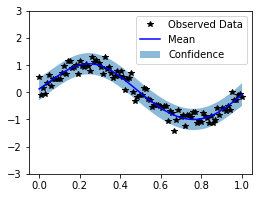

In [9]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(X_train.numpy(), Y_train.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

